## Imports & Constants

In [1]:
import sys
!{sys.executable} -m pip install gtab  # Has to be checked first or else gtab is imported as module from the data folder gtab

In [2]:
import datetime
import gtab
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import statsmodels.formula.api as smf

from utils.query_google import TrendsQueryer
from utils.plot_split_timeseries import split_timeseries_figures

In [3]:
PRISM_DATE = datetime.datetime(2013, 6, 6)

# GTAB information
TIMEFRAME = '2011-01-01 2015-12-31'
GEO_CODES = ['', 'ar', 'de', 'es', 'fr', 'hi', 'it', 'ja', 'pt', 'ru']

GOOGLE_DATA = 'data/GoogleTrends'
WIKI_DATA = 'data/Wikipedia'

## Data Loading / Wrangling

### Load or Query Google
Using our prepared utility functions to query relevant keywords from google trends, using the dlabs GTAB library.

In [4]:
all_google_trends = {}
# for location in GEO_CODES:
#     try:
#         gt = TrendsQueryer(TIMEFRAME, geo_code=location)
#         location_code = location if location != '' else 'en'
#         gt_terror = gt.load_or_query('terrorism_' + location_code)
#         gt_domestic = gt.load_or_query('domestic_' + location_code)
#         all_google_trends[location] = {'terror': gt_terror, 'domestic': gt_domestic}
#     # Usually, we want the WorldWide data:
#     except ConnectionError as exe:
#         "Skipping {}. {}".format(location, exe)
gt = TrendsQueryer(TIMEFRAME, geo_code='')
gt_terror = gt.load_or_query('terrorism_en')
gt_domestic = gt.load_or_query('domestic_en')

Directory already exists, loading data from it.
Using directory '/home/jonathan/Documents/ada-2020-project-milestone-p3-p3_0x414441/gtab/'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Active anchorbank changed to: google_anchorbank_geo=_timeframe=2011-01-01 2015-12-31.tsv

Loaded terrorism_en.csv
Loaded domestic_en.csv


In [5]:
gt_terror.sample(frac=1).head()

,article,date,max_ratio,max_ratio_hi,max_ratio_lo,lanuage
89,Abu Sayyaf,2012-09-16,0.030000,0.035000,0.025000,en.csv
6445,Tehrik-i-Taliban Pakistan,2014-06-22,0.000000,0.000203,0.000000,en.csv
2684,Dirty bomb,2012-06-03,0.028986,0.036496,0.021583,en.csv
11314,somalia,2012-09-30,1.920123,2.014616,1.830065,en.csv
2006,Car bomb,2014-06-08,0.191489,0.204301,0.178947,en.csv


#### Concatenate the dataframes to one:

In [6]:
# Concatenate the dataframes into one
gt_terror['topic'] = 'terror'
gt_domestic['topic'] = 'domestic'
google = pd.concat([gt_terror, gt_domestic])
# Create a column that simplifies the month and only leaves the month
google['date'] = pd.to_datetime(google['date'])
google['month'] = google.date.dt.to_period('M')

### Wikipedia

In [7]:
def analyse_and_plot(dataset='wikipedia', lang=None, ignore_months=range(54, 60+1), split=42):
    """
    (month 42 is June 2013 since the data starts in January 2010)
    """
    
    # Read both csv files
    df_terrorism = pd.read_csv(f'data/{dataset}/terrorism_views.csv')
    df_domestic = pd.read_csv(f'data/{dataset}/domestic_views.csv')
    
    # Group them
    df = pd.concat([df_terrorism, df_domestic])
    
    # Create a mapping from article name to study group
    group = {}
    for article in df_terrorism.article.unique():
        group[article] = 'terrorism'
    for article in df_domestic.article.unique():
        group[article] = 'domestic'
    
    if lang is not None:
        # Keep only articles in this language
        df = df.loc[df.language == lang]
    
    # We extract the month, year, time (number of months elapsed since the beginning of the period)
    df['month'] = pd.DatetimeIndex(df.date).month
    df['year'] = pd.DatetimeIndex(df.date).year
    df['time'] = (df.year - df.year.min()) * 12 + df.month
    
    
    # Get the total number of views for each article for each month
    monthly_views = df.groupby(['article', 'time'])['views'].sum().reset_index()\
                                  .pivot_table(index='article', columns='time', values='views')
    
    # Retrieve the monthly pageviews for each article group
    terrorism_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'terrorism')]
    domestic_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'domestic')]
    
    # DataFrame to apply the ITS analysis to
    its = pd.DataFrame()

    # Monthly number of views aggregated over all terrorism articles
    its['t_views'] = terrorism_views.sum()
    # Monthly number of views aggregated over all terrorism articles
    its['d_views'] = domestic_views.sum()

    # Indicator of whether the NSA revelations have already happened
    its['NSA'] = (its.index.to_series() >= split).astype(int)
    # We just do this to be able to use the column 'month' in the regression
    its['month'] = its.index
    
    # Fitting the ITS regressions
    terrorism_regr = smf.ols(formula='t_views ~ month * NSA', data=its.drop(ignore_months)).fit()
    domestic_regr = smf.ols(formula='d_views ~ month * NSA', data=its.drop(ignore_months)).fit()
    
    # Retrieve the ITS predictions and confidence intervals
    its['t_pred'] = terrorism_regr.predict(its)
    its[['t_low', 't_high']] = terrorism_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values
    its['d_pred'] = domestic_regr.predict(its)
    its[['d_low', 'd_high']] = domestic_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values
    
    
    ## Plotting
    fig = plt.figure(figsize=(16, 8))
    plt.ticklabel_format(axis='y', style='plain')

    # Plot the actual monthly pageviews as dots
    plt.plot(its['t_views'].drop(ignore_months), 'o', label='terrorism article views')
    plt.plot(its['t_views'].loc[ignore_months[:-1]], 'o', color='paleturquoise', label='ignored terrorism entries')

    plt.plot(its['d_views'].drop(ignore_months), 'o', label='domestic article views')
    plt.plot(its['d_views'].loc[ignore_months[:-1]], 'o', color='navajowhite', label='ignored domestic entries')

    
    # Plot the regression line before the June 2013 revelations (June 2013 excluded)
    plt.plot(its.loc[:split-1, 't_pred'], 'k-', label='trend before NSA revelations')
    # Plot the regression line after the June 2013 revelations (June 2013 included)
    plt.plot(its.loc[split:, 't_pred'], 'k--', label='trend after NSA revelations')

    # Plot the regression line before the June 2013 revelations (June 2013 excluded)
    plt.plot(its.loc[:split-1, 'd_pred'], 'k-')
    # Plot the regression line after the June 2013 revelations (June 2013 included)
    plt.plot(its.loc[split:, 'd_pred'], 'k--')

    # Plot the regression confidence intervals
    plt.fill_between(its.loc[:split-1].index, its.loc[:split-1]['t_low'], its.loc[:split-1]['t_high'],
                     alpha=0.3, color='mediumturquoise', label='terrorism 95% CI')
    plt.fill_between(its.loc[split:].index, its.loc[split:]['t_low'], its.loc[split:]['t_high'],
                     alpha=0.3, color='mediumturquoise')

    plt.fill_between(its.loc[:split-1].index, its.loc[:split-1]['d_low'], its.loc[:split-1]['d_high'],
                     alpha=0.3, color='orange', label='domestic 95% CI')
    plt.fill_between(its.loc[split:].index, its.loc[split:]['d_low'], its.loc[split:]['d_high'],
                     alpha=0.3, color='orange')

    # Show the moment of the NSA revelations
    plt.axvline(x=split-0.5, color='r', label='NSA revelations (June 2013)')

    # Show legend, set title, axis labels, x ticks
    plt.legend(ncol=5)
    plt.title(f'[{lang if lang is not None else "all languages"}] Terrorism study group (25 articles)'
              ' vs Domestic security comparator group (24 articles)')
    plt.xlabel('time (month)')
    plt.xticks(range(0, 120+1, 6))
    plt.ylabel('total pageviews')
    
    # Return the regression and the figure
    return (terrorism_regr, domestic_regr), fig

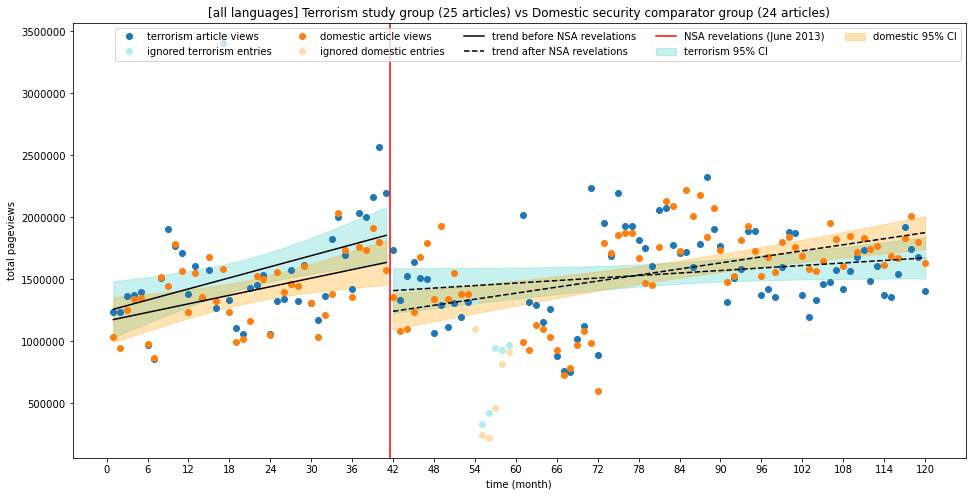

In [8]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia')

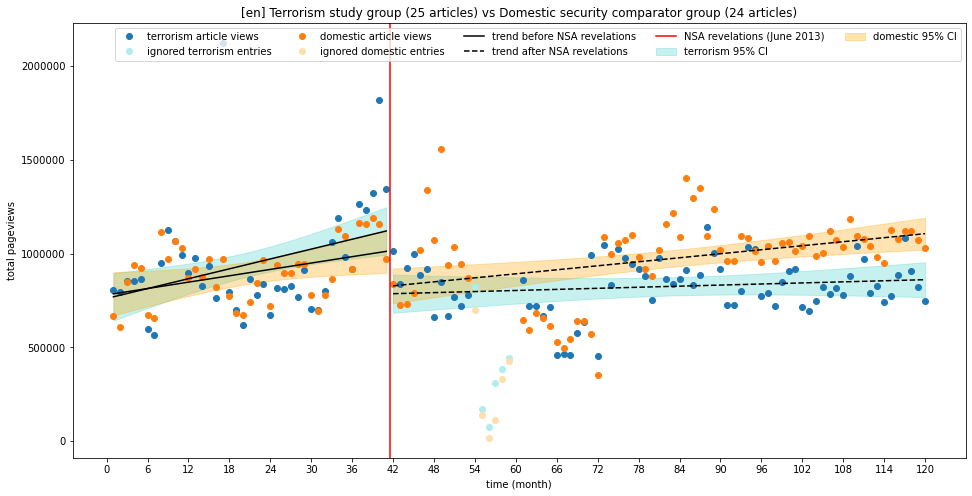

In [9]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='en')

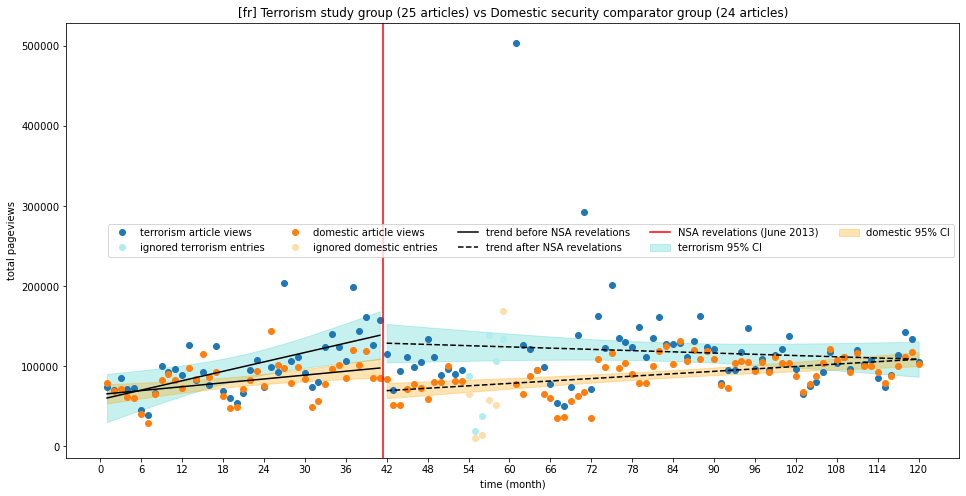

In [10]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='fr')

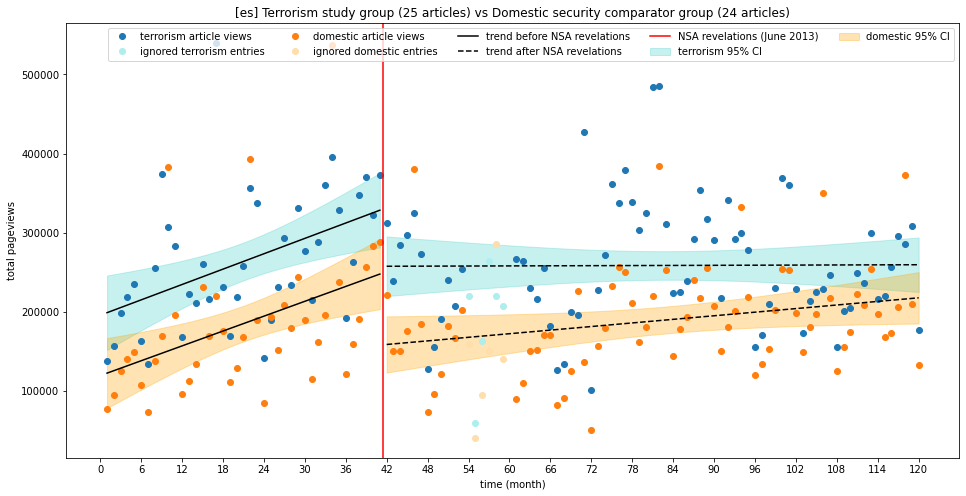

In [11]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='es')

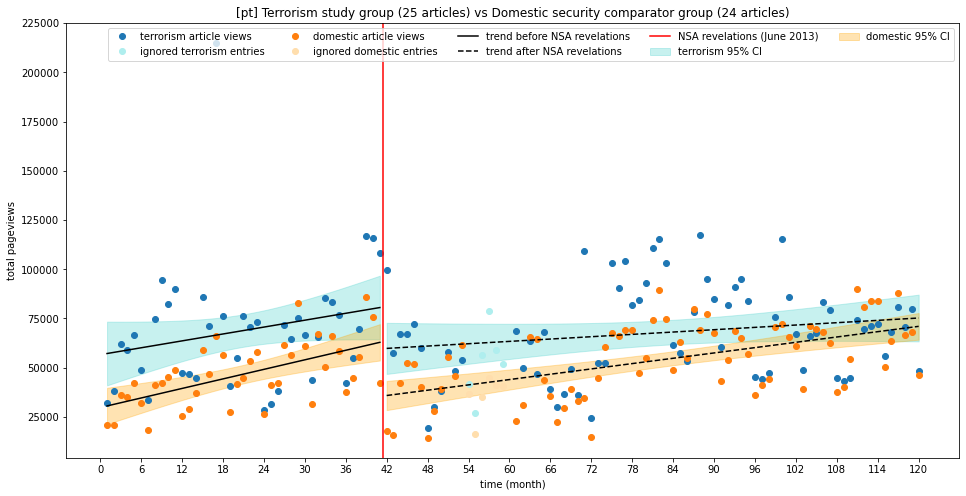

In [12]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='pt')

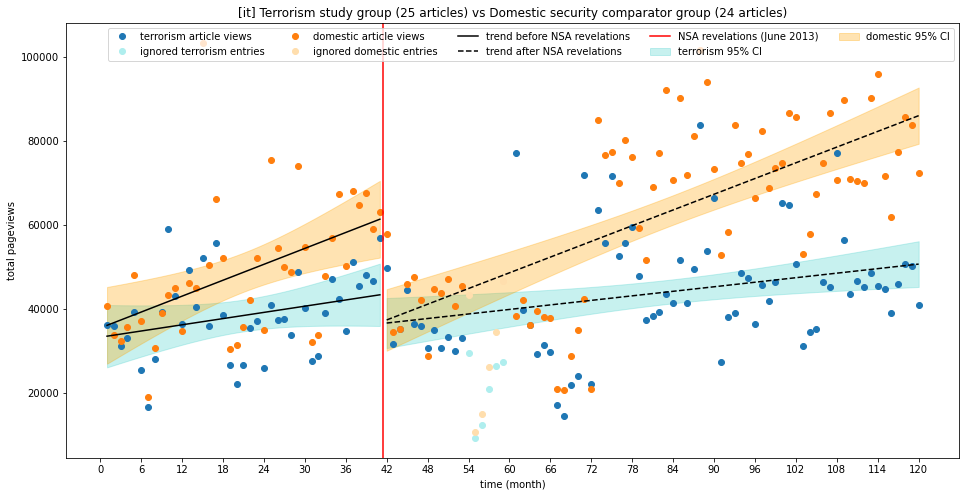

In [13]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='it')

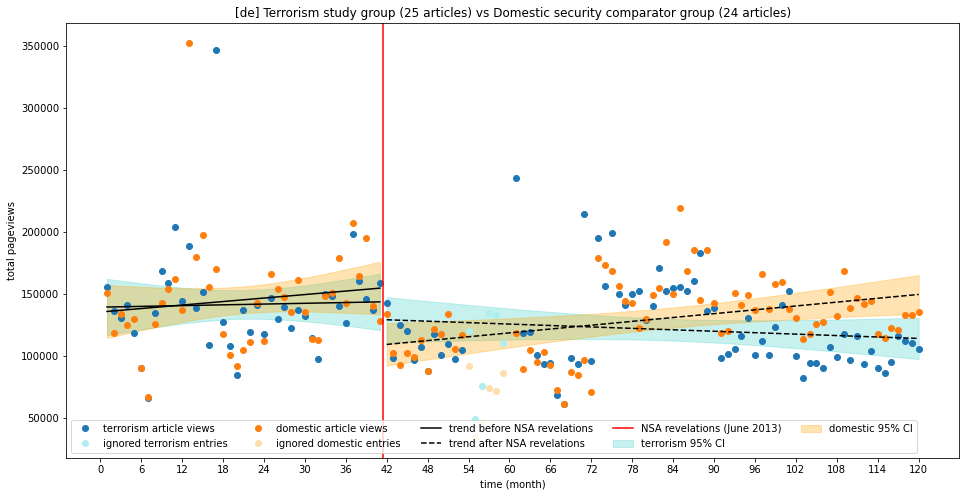

In [14]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='de')

## Exploring the Wikipedia Data

In [15]:
fig = plt.figure(figsize=(10, 5))

ax = monthly_views.sum().plot(fig=fig, style='.:', label='total')
terrorism_views.sum().plot(fig=fig, style='.:', label='terrorism group')
domestic_views.sum().plot(fig=fig, style='.:', label='domestic security group')

ax.set_xlabel('month')
ax.set_ylabel('pageviews')
plt.legend()
fig.suptitle('Monthly pageviews for the two article groups over the studied period');

NameError: name 'monthly_views' is not defined

<Figure size 720x360 with 0 Axes>

We can see a strange drop of pageviews around month 55 (July 2014), let's try to understand it.

In [ ]:
# We count the number of zeros for each article for each month
df['zeros'] = (df['views'] == 0).astype(int)
zeroes = df.groupby(['article', 'time'])['zeros'].mean().reset_index().pivot_table(index='article', columns='time', values='zeros')

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = zeroes.mean().plot(fig=fig, style='.:')

ax.set_xlabel('month')
ax.set_ylabel('proportion')
ax.set_yticks([i / 10 for i in range(11)])
fig.suptitle('Mean proportion of missing entries (0 views on a given day) per month averaged over all articles');

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = zeroes.mean().loc[52:63].plot(fig=fig, style='.:')

ax.set_xlabel('month')
ax.set_xticks(range(52, 63+1))
ax.set_ylabel('proportion')
ax.set_yticks([i / 10 for i in range(11)])
fig.suptitle('Mean proportion of missing entries (0 views on a given day) per month (focus on months 52-63)');

This sudden increase in missing entries might be due to a Wikipedia outage during the months 54 to 60 (June to December 2014).

In any case, we will not consider these months during our analysis as this would surely affect the results. To do so, in the regression we will simply drop the entries corresponding to the mentioned months, without shifting the month numbers after them.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 10))

terrorism_views.T.iloc[:,  0: 12].plot(ax=axes[0, 0])
terrorism_views.T.iloc[:, 12: 24].plot(ax=axes[0, 1])
terrorism_views.T.iloc[:, 24: 36].plot(ax=axes[1, 0])
terrorism_views.T.iloc[:, 36: 48].plot(ax=axes[1, 1])

axes[0, 0].set_ylabel('monthly pageviews')
axes[1, 0].set_ylabel('monthly pageviews')

axes[0, 0].legend(ncol=2)
axes[1, 0].legend(ncol=2)
axes[0, 1].legend(ncol=2)
axes[1, 1].legend(ncol=2)

fig.suptitle('Monthly pageviews of the 48 articles in the terrorism-related group'
             ' (split alphabetically into 4 subplots of 12 articles each).')

fig.set_tight_layout(True)

As we can see, there is a spike of pageviews for `al-qaeda` on around month 17 (May 2011, when Al-Qaeda's emir Osama bin Laden was killed), and for `hamas` around month 34 (October 2012, during the Operation "Pillar of Defense" conflict).

Since these mediatized events are expected to increase the number of pageviews, and have little to do with chilling effects, we will not consider them in our analysis.

In [ ]:
terrorism_clean = terrorism_views.drop(['hamas', 'al-qaeda'])

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 10))

domestic_views.T.iloc[:,  0:  6].plot(ax=axes[0, 0])
domestic_views.T.iloc[:,  6: 12].plot(ax=axes[0, 1])
domestic_views.T.iloc[:, 12: 18].plot(ax=axes[1, 0])
domestic_views.T.iloc[:, 18: 25].plot(ax=axes[1, 1])

axes[0, 0].set_ylabel('monthly pageviews')
axes[1, 0].set_ylabel('monthly pageviews')


fig.suptitle('Monthly pageviews of the 25 articles in the domestic security-related group'
             ' (split alphabetically into 4 subplots of 6-7 articles each).')

fig.set_tight_layout(True)

We can see that `united_nations` has considerably more views than the other topics, with a spike around month 50 (February 2014, we can't explain it). We will not consider this article for our analysis to remove oscillations due only to it.

In [111]:
domestic_clean = domestic_views.drop('united_nations')

NameError: name 'domestic_views' is not defined

## Exploring the Google Trends Data

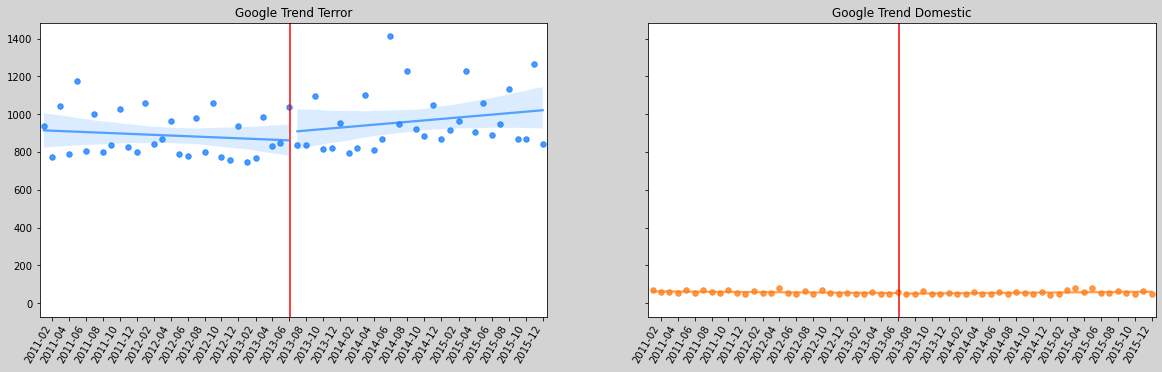

In [112]:
monthly_interest = google.groupby(['article', 'month', 'topic']).sum().reset_index().set_index('month')
terror = monthly_interest.loc[monthly_interest.topic == 'terror'].groupby('month').sum()
domestic = monthly_interest.loc[monthly_interest.topic == 'domestic'].groupby('month').sum()
split_timeseries_figures([terror, domestic],
                        names=['Google Trend Terror', 'Google Trend Domestic'],
                        keyword='max_ratio',
                        figsize=[20, 6],
                        same_plot=False,
                        sharey=True,
                        colors={'Google Trend Terror': [0.1, 0.5, 1, 0.7],
                               'Google Trend Domestic': [1, 0.5, 0.1, 0.7]})

There seem to be no major anomalies in the data, but a closer look can never hurt. Especially the terror peak in June 2014 might be worth a closer observation. So first, let's see which articles contributed the most to the high count and how much larger the interest in those articles were than usually:

In [113]:
jun14 = monthly_interest.loc['2014-06']
mean_ratio = monthly_interest.groupby('article')['max_ratio'].mean()
interest_increase = jun14.apply(lambda row: row['max_ratio'] / mean_ratio[row['article']], axis=1)
jun14.insert(loc=5, column='interest_increase', value=interest_increase)
jun14.loc[jun14.topic == 'terror'].sort_values(by='max_ratio', ascending=False).head(5)

,article,topic,max_ratio,max_ratio_hi,max_ratio_lo,interest_increase
month,,,,,,
2014-06,nigeria,terror,314.710941,343.654875,288.442681,2.993572
2014-06,pakistan,terror,204.658649,225.296399,186.005093,1.140807
2014-06,attack,terror,183.420487,202.455289,166.236436,1.324042
2014-06,iran,terror,164.113067,181.690644,148.264929,2.886248
2014-06,recruitment,terror,142.231325,150.761306,134.276435,1.278841


We can see that especially the articles nigeria and iran seem to trigger a highly increased interest in this month. But why is that?
Nigeria suffered from bombings and many deaths in June 2014 due to the Islamist insurgency that started in 2009 but seemed to reach a peak in the summer of 2014.

Another reason for the increased interest could be something completely different: The 2014 FIFA World Cup. Both countries, Nigeria and Iran had teams participate and Nigeria even managed to get into the knockout stage. The world cup usually has a huge public resonance. The 2014 one for example ranks as the 10th-most watched television broadcast of all times - it seems to be reasonable that the interest int participating countries also automatically increases.

Whatever reason caused the rising interest for terror-related articles in 2014, it seems to be safer to ignore this month in the analysis and consider it an outlier.

Also, it seems to be reasonable to drop the June 2013, as it falls in both, the pre- and the post-Snowden era.

In [116]:
monthly_interest.drop(monthly_interest.loc[['2013-06', '2014-06']].index, inplace=True)

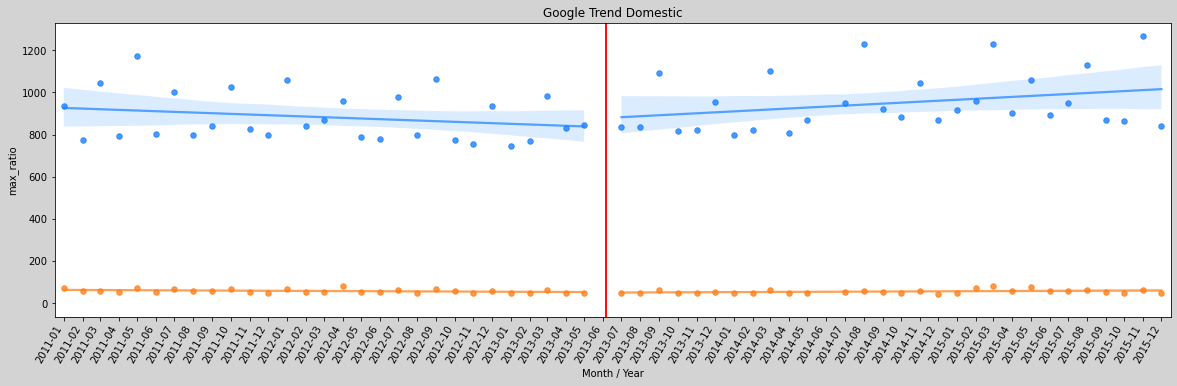

In [122]:
terror = monthly_interest.loc[monthly_interest.topic == 'terror'].groupby('month').sum()
domestic = monthly_interest.loc[monthly_interest.topic == 'domestic'].groupby('month').sum()
split_timeseries_figures([terror, domestic],
                        names=['Google Trend Terror', 'Google Trend Domestic'],
                        keyword='max_ratio',
                        figsize=[20, 6],
                        legend=False,
                        colors={'Google Trend Terror': [0.1, 0.5, 1, 0.7],
                               'Google Trend Domestic': [1, 0.5, 0.1, 0.7]})

## Regression

In [ ]:
# DataFrame to apply the ITS analysis to
its = pd.DataFrame()

# Monthly number of views aggregated over the 46 terrorism articles
its['terrorism_views'] = terrorism_clean.sum()
# Monthly number of views aggregated over the 24 domestic articles
its['domestic_views'] = domestic_clean.sum()

# Indicator of whether the NSA revelations have already happened (month 42 is June 2013)
its['NSA'] = (its.index.to_series() >= 42).astype(int)
# We just do this to be able to use the column 'month' in the regression
its['month'] = its.index
its.head(3)

In [ ]:
terrorism_regr = smf.ols(formula='terrorism_views ~ month * NSA', data=its.drop(range(54, 60+1))).fit()
print(terrorism_regr.summary())
its['terrorism_regr'] = terrorism_regr.predict(its)
its[['terrorism_lower', 'terrorism_upper']] = terrorism_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values

In [ ]:
domestic_regr = smf.ols(formula='domestic_views ~ month * NSA', data=its.drop(range(54, 60+1))).fit()
print(domestic_regr.summary())
its['domestic_regr'] = domestic_regr.predict(its)
its[['domestic_lower', 'domestic_upper']] = domestic_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values

In [ ]:
its

In [ ]:
plt.figure(figsize=(16, 8))
plt.ticklabel_format(axis='y', style='plain')

# Plot the actual monthly pageviews as dots
plt.plot(its['terrorism_views'].drop(range(55, 60+1)), 'o', label='terrorism article views')
plt.plot(its['terrorism_views'].loc[55:60], 'o', color='paleturquoise', label='ignored terrorism entries')

# Plot the actual monthly pageviews as dots
plt.plot(its['domestic_views'].drop(range(55, 60+1)), 'o', label='domestic article views')
plt.plot(its['domestic_views'].loc[55:60], 'o', color='navajowhite', label='ignored domestic entries')

# Plot the regression line before the June 2013 revelations (June 2013 excluded)
plt.plot(its.loc[:41, 'terrorism_regr'], 'k-', label='trend before NSA revelations')
# Plot the regression line after the June 2013 revelations (June 2013 included)
plt.plot(its.loc[42:, 'terrorism_regr'], 'k--', label='trend after NSA revelations')

# Plot the regression line before the June 2013 revelations (June 2013 excluded)
plt.plot(its.loc[:41, 'domestic_regr'], 'k-')
# Plot the regression line after the June 2013 revelations (June 2013 included)
plt.plot(its.loc[42:, 'domestic_regr'], 'k--')

# Plot the regression confidence intervals
plt.fill_between(its.loc[:41].index, its.loc[:41]['terrorism_lower'], its.loc[:41]['terrorism_upper'],
                 alpha=0.3, color='mediumturquoise', label='terrorism 95% CI')
plt.fill_between(its.loc[42:].index, its.loc[42:]['terrorism_lower'], its.loc[42:]['terrorism_upper'],
                 alpha=0.3, color='mediumturquoise')

plt.fill_between(its.loc[:41].index, its.loc[:41]['domestic_lower'], its.loc[:41]['domestic_upper'],
                 alpha=0.3, color='orange', label='domestic 95% CI')
plt.fill_between(its.loc[42:].index, its.loc[42:]['domestic_lower'], its.loc[42:]['domestic_upper'],
                 alpha=0.3, color='orange')

# Show the moment of the NSA revelations
plt.axvline(x=41.5, color='r', label='NSA revelations (June 2013)')

# Show legend, set title, axis labels, x ticks
plt.legend(ncol=5)
plt.title('Terrorism study group (46 articles, hamas and al-qaeda exluded)'
          ' vs Domestic security comparator group (24 articles, united_nations excluded)')
plt.xlabel('time (month)')
plt.xticks(range(0, 120+1, 5))
plt.ylabel('total pageviews');